### This part of the code contains the code to load and preprocssing the dataset

In [11]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import os
import torchvision as tv
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import wandb
import torch.optim as opt
from wandb import Api

transform = transforms.Compose([
    transforms.CenterCrop(224),  # or RandomResizedCrop(224)
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


data = '/mnt/e_disk/DA24S008/DA6401_Assignment_2/dataset/inaturalist_12K' #This is the path to the dataset folder. I have kept inaturalist_12K folder inside a folder called dataset. when you are running this, copy paste the path of the "dataset" folder
trainset = ImageFolder(root=os.path.join(data, 'train'), transform=transform)
testset = ImageFolder(root=os.path.join(data, 'val'), transform=transform)


train_size = int(0.8 * len(trainset)) # I am keeping 80% of the actual training dataset for training and the remaining 20% will be for validation set.
val_size = len(trainset) - train_size

train_subset, val_subset = random_split(trainset, [train_size, val_size])

classes = trainset.classes

print(f"Classes: {classes}")
print(f"Training samples: {len(train_subset)}")
print(f"Validation samples: {len(val_subset)}")
print(f"Test samples: {len(testset)}")

Classes: ['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']
Training samples: 7301
Validation samples: 1826
Test samples: 2000


### Question 1 (5 Marks)
Build a small CNN model consisting of $5$ convolution layers. Each convolution layer would be followed by an activation and a max-pooling layer. 

After $5$ such conv-activation-maxpool blocks, you should have one dense layer followed by the output layer containing $10$ neurons ($1$ for each of the $10$ classes). The input layer should be compatible with the images in the [iNaturalist dataset](https://storage.googleapis.com/wandb_datasets/nature_12K.zip) dataset.

The code should be flexible such that the number of filters, size of filters, and activation function of the convolution layers and dense layers can be changed. You should also be able to change the number of neurons in the dense layer.




In [ ]:
batch_size = 10
trainloader1 = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
class ConvNN(nn.Module):
    def __init__(self,
                 m =[16, 32, 64, 128, 256],
                 k=[3, 3, 3, 3, 3],
                 pool_params=[{'kernel_size': 2, 'stride': 2}]*5,
                 activations=[F.relu]*5,
                 dense_neurons=512,
                 dense_activation=F.relu,
                 num_classes=10):
        super(ConvNN, self).__init__()

        self.activations = activations
        self.conv_layers = nn.ModuleList()
        self.pool_layers = nn.ModuleList()

        in_channels = 3
        for i in range(5):
            self.conv_layers.append(
                nn.Conv2d(in_channels, m[i], kernel_size=k[i])
            )
            in_channels = m[i]

            pool_config = pool_params[i]
            self.pool_layers.append(nn.MaxPool2d(**pool_config))

        sample_input, _ = next(iter(trainloader1)) 
        sample_image = sample_input[0].unsqueeze(0)

        with torch.no_grad():
            x = sample_image
            for i in range(5):
                x = self.pool_layers[i](self.activations[i](self.conv_layers[i](x)))
            conv_output_shape = x.numel()

        self.fc = nn.Linear(conv_output_shape, dense_neurons)
        self.fc_out = nn.Linear(dense_neurons, num_classes)
        self.dense_activation = dense_activation

    def forward(self, x):
        for i in range(5):
            x = self.pool_layers[i](self.activations[i](self.conv_layers[i](x)))
        x = torch.flatten(x, 1)
        x = self.dense_activation(self.fc(x))
        x = self.fc_out(x)
        return x




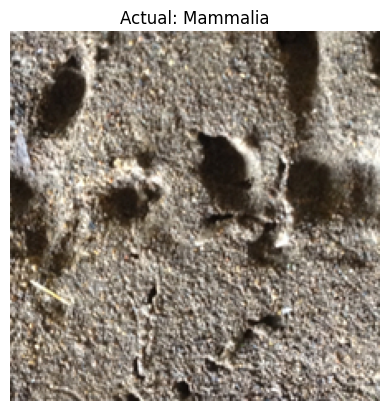

y   : Mammalia
y': Insecta


In [4]:
#The below piece of code contains the parameters of the 5 conv-activation-maxpool blocks and the dense layer.
model = ConvNN(
    m=[16, 32, 64, 128, 256], #Here we can customise the number of filters in each convolution layer. (ex: 1st convolution layer contains 16 filters and 2nd one has 32 and so on)
    k=[3, 3, 3, 3, 3], #Here we can customise the size of filters in each layer. I have kept all of them as 3X3 filters.
    pool_params=[
        {'kernel_size': 2, 'stride': 2}, #Filter size and Stride length for 1st maxpooling layer
        {'kernel_size': 3, 'stride': 2}, #Filter size and Stride length for 2nd maxpooling layer
        {'kernel_size': 2, 'stride': 1}, #Filter size and Stride length for 3rd maxpooling layer 
        {'kernel_size': 2, 'stride': 2}, #Filter size and Stride length for 4th maxpooling layer
        {'kernel_size': 3, 'stride': 2}, #Filter size and Stride length for 5th maxpooling layer
    ],
    dense_neurons=512,
    num_classes=10
)

#This code is for visualizing the output of the model's forward pass. The model is not yet trained, so the predictions are wrong. The training code is in the 2nd question's answer.
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

dataiter = iter(trainloader1)
images, labels = next(dataiter)
imshow(tv.utils.make_grid(images[0].unsqueeze(0)))
plt.title("Actual: " + classes[labels[0]])
plt.show()
model = ConvNN()
with torch.no_grad():
    outputs = model(images[0].unsqueeze(0))  # Add batch dimension
    _, predicted = torch.max(outputs, 1)

print(f"y   : {classes[labels[0]]}")
print(f"y': {classes[predicted[0]]}")

- What is the total number of computations done by your network? (assume $m$ filters in each layer of size $k\times k$  and $n$ neurons in the dense layer)

    Let the input images be N X N. Assuming m filters in each convolution layer, each filter is a k X k filter. Each convolution layer is followed by an activation and max pooling. There are 5 convolution layers, first layer maps from 3 channels (RGB) to m filters and the other 4 layers maps from m channels to m channels. We will assume the pooling layer also has the filter size of k X k. 

    Assuming no padding, and stride = 1, 

    - Spatial sizes after every layer:
            - After convolution "l" : N_(l-1)  X  N_(l-1), where l-1 denotes previous layer
            - After pooling l: N_l = N/k^l, where l = 1,2,3,4,5

    - Convolution computations:
        - For layer 1, input channels is 3 (RGB):

            - computation = m * (N^2) * (k^2 * 3) = 3 * m * k^2 * N^2

        - for layers 2 to 5, input channels will be m:

            - sum[m * ((N_(l-1))^2) * (k^2 * m)], where l goes from 2 to 5
                = m^2 * k^2 * N^2 * sum(1/(k^2i)), where the sum is over i = 1 to 4

        - total convolution computations:

            = 3 * m * k^2 * N^2 + m^2 * k^2 * N^2 * sum(1/(k^2i)), where the sum is over i = 1 to 4

    - Activation costs: 

        I am assuming ReLU

        - sum(m * (N_(l-1)^2)), where the sum is over l = 1 to 5.
                
            = m * N^2 * sum(1/k^2i), where the sum is over i = 0 to 4.

    - max pooling does not invove any computation as there is no multiplication or addition involved. 

    - Dense layer:

        - The dimension of the dense layer will be D = m * (N_5)^2 = m * (N^2)/(k^10)
        - A Single fully connected layer to n neurons costs D * n

            = m * n * (N^2)/(k^10)

    - Total computations would be the sum of all the above computations:

        = [3 * m * k^2 * N^2 + m^2 * k^2 * N^2 * sum_i(1/(k^2i))] +  [m * N^2 * sum_i(1/k^2i)] + [m * n * (N^2)/(k^10)]




- What is the total number of parameters in your network? (assume $m$ filters in each layer of size $k\times k$ and $n$ neurons in the dense layer)

    - m is the number of filters in each convolution layer
    - k is the filter size
    - Images are N X N dimensional
    - n is the number of neurons in the dense layer
    - C is the number of output classes
 
    - The number of parameters in first convolution layer: (convolution from 3 to m with k X k filter, + bias)

        = (3 * k^2) * m + m
        = 3 * m * k^2 + m
    
    - The number of parameters in convolution layers 2 to 5: (convolution from m to m with k X k filter, + bias)
        thre are 4 layers, so:

        = 4 * (m^2 * k^2) + m
        = (4 * m^2 * k^2) + (4 * m)

    - Dense layer: ((input is m*(N/k^5)^2), output = n, bias)

        = [n * (m * (N^2)/k^10)] + n

    - output layer: (n to C + bias)

        = C * n + C

    
    - Total number of parameters is the sum of all parameters:

        = [3 * m * k^2 + m] + [(4 * m^2 * k^2) + (4 * m)] + [[n * (m * (N^2)/k^10)] + n] + [C * n + C]



### Question 2 (15 Marks)
You will now train your model using the [iNaturalist dataset](https://storage.googleapis.com/wandb_datasets/nature_12K.zip). The zip file contains a train and a test folder. Set aside $20\%$ of the training data, as validation data, for hyperparameter tuning. Make sure each class is equally represented in the validation data. **Do not use the test data for hyperparameter tuning.**

Using the sweep feature in wandb find the best hyperparameter configuration. Here are some suggestions but you are free to decide which hyperparameters you want to explore

- number of filters in each layer : $32$, $64$, ...
- activation function for the conv layers: ReLU, GELU, SiLU, Mish, ...
- filter organisation: same number of filters in all layers, doubling in each subsequent layer, halving in each subsequent layer, etc
- data augmentation: Yes, No
- batch normalisation: Yes, No
- dropout: $0.2$, $0.3$ (BTW, where will you add dropout? You should read up a bit on this)

Based on your sweep please paste the following plots which are automatically generated by wandb:
- accuracy v/s created plot (I would like to see the number of experiments you ran to get the best configuration). 
- parallel co-ordinates plot
- correlation summary table (to see the correlation of each hyperparameter with the loss/accuracy)

Also, write down the hyperparameters and their values that you sweeped over. Smart strategies to reduce the number of runs while still achieving a high accuracy would be appreciated. Write down any unique strategy that you tried.

In [ ]:
activation_map = {
    'relu': F.relu,
    'gelu': F.gelu,
    'silu': F.silu,
    'mish': F.mish,
    'sigmoid': F.sigmoid
}

activation_module_map = {
    'relu': nn.ReLU,
    'gelu': nn.GELU,
    'silu': nn.SiLU,
    'mish': nn.Mish,
    'sigmoid': nn.Sigmoid
}

def init_weights(m, method):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        if method == 'xavier':
            nn.init.xavier_uniform_(m.weight)
        else:
            nn.init.kaiming_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

def generate_filters(base_m, strategy):
    if strategy == 'same':
        return [base_m] * 5
    elif strategy == 'double':
        return [base_m * (2 ** i) for i in range(5)]
    elif strategy == 'half':
        return [max(1, base_m // (2 ** i)) for i in range(5)]

class ConvNNconfig(nn.Module):
    def __init__(self, m, k=[3, 3, 3, 3, 3], pool_params=None,
                 activation='relu', dense_neurons=512, dropout=0.0,
                 batch_norm=False, num_classes=10):
        super(ConvNNconfig, self).__init__()
        if pool_params is None:
            pool_params = [{'kernel_size': 2, 'stride': 2}] * 5

        act_fn = activation_map[activation]
        act_module = activation_module_map[activation]

        self.layers = nn.ModuleList()
        in_channels = 3

        for i in range(5):
            conv_block = [nn.Conv2d(in_channels, m[i], kernel_size=k[i], padding=1)]
            if batch_norm:
                conv_block.append(nn.BatchNorm2d(m[i]))
            conv_block.append(act_module())
            if dropout > 0:
                conv_block.append(nn.Dropout2d(dropout))
            conv_block.append(nn.MaxPool2d(**pool_params[i]))

            self.layers.append(nn.Sequential(*conv_block))
            in_channels = m[i]

        self.flatten = nn.Flatten()

        with torch.no_grad():
            sample_image = torch.randn(1, 3, 224, 224)
            x = sample_image
            for block in self.layers:
                x = block(x)
            conv_output_shape = x.view(1, -1).size(1)

        self.fc1 = nn.Linear(conv_output_shape, dense_neurons)
        self.fc2 = nn.Linear(dense_neurons, num_classes)
        self.act = act_module()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        for block in self.layers:
            x = block(x)
        x = self.flatten(x)
        x = self.dropout(self.act(self.fc1(x)))
        return self.fc2(x)

def train_model(config=None):
    with wandb.init(config=config):
        config = wandb.config
        wandb.run.name = f"fo_{config.filter_org}/bn_{config.batch_norm}/act_{config.activation}/aug_{config.data_aug}"

        #The dataset preprocessing is already done in the first cell, but it is kind of hard coded. Here, I have made it such that the wandb config can be used for hyperparameter tuning.
        #Especially for data augmentation.
        if config.data_aug == 'yes':
            transform_train = transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
        else:
            transform_train = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])


        #No need of any augmentation for validation set.
        transform_val = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

        data = '/mnt/e_disk/DA24S008/DA6401_Assignment_2/dataset/inaturalist_12K'

        #This is the complete training dataset provided by iNaturalist_12K
        full_trainset = ImageFolder(root=os.path.join(data, 'train'), transform=transform_train)
        
        #same as cell 1, we will split the dataset into training and validation sets. 

        train_size = int(0.8 * len(full_trainset))
        val_size = len(full_trainset) - train_size
        train_subset, val_subset = random_split(full_trainset, [train_size, val_size])

        trainloader = DataLoader(train_subset, batch_size=config.batch_size, shuffle=True, num_workers=2)
        valloader = DataLoader(val_subset, batch_size=config.batch_size, shuffle=False, num_workers=2)

        m = generate_filters(config.m, config.filter_org)

        model = ConvNNconfig(
            m=m,
            k=config.k,
            activation=config.activation,
            dropout=config.dropout,
            batch_norm=config.batch_norm == 'yes',
            num_classes=len(full_trainset.classes)
        )
        model.apply(lambda m: init_weights(m, config.weight_init))

        device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        model.to(device)

        if config.optim_algo == 'sgd':
            optimizer = opt.SGD(model.parameters(), lr=config.lr)
        elif config.optim_algo == 'momentum':
            optimizer = opt.SGD(model.parameters(), lr=config.lr, momentum=0.9)
        elif config.optim_algo == 'adam':
            optimizer = opt.Adam(model.parameters(), lr=config.lr)
        elif config.optim_algo == 'nadam':
            optimizer = opt.NAdam(model.parameters(), lr=config.lr)
        elif config.optim_algo == 'nesterov':
            optimizer = opt.SGD(model.parameters(), lr=config.lr, momentum=0.9, nesterov=True)
        elif config.optim_algo == 'rmsprop':
            optimizer = opt.RMSprop(model.parameters(), lr=config.lr)

        criterion = nn.CrossEntropyLoss()

        for epoch in range(config.epochs):
            model.train()
            total_loss, correct, total = 0.0, 0, 0
            for inputs, labels in trainloader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                total_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

            train_acc = correct / total
            train_loss = total_loss / total

            model.eval()
            val_loss, val_correct, val_total = 0.0, 0, 0
            with torch.no_grad():
                for inputs, labels in valloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * inputs.size(0)
                    _, predicted = outputs.max(1)
                    val_total += labels.size(0)
                    val_correct += predicted.eq(labels).sum().item()

            val_acc = val_correct / val_total
            val_loss /= val_total

            best_val_acc = 0.0
            best_epoch = 0
            save_path = os.path.join(wandb.run.dir, 'best_model.pth')

            for epoch in range(config.epochs):
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_epoch = epoch + 1
                    torch.save(model.state_dict(), save_path)

                    artifact = wandb.Artifact('best-model', type='model')
                    artifact.add_file(save_path)
                    wandb.log_artifact(artifact)

            wandb.log({
                'epoch': epoch + 1,
                'train_loss': train_loss,
                'train_acc': train_acc,
                'val_loss': val_loss,
                'val_acc': val_acc
            })

config_params = {
    'method': 'bayes',
    'metric': {'name': 'val_acc', 'goal': 'maximize'},
    'parameters': {
        'epochs': {'values': [10, 15, 20]},
        'loss': {'values': ['cross_entropy']},
        'm': {'values': [32, 64, 128]},
        'k': {'values': [[5, 5, 5, 5, 5], [3, 3, 3, 3, 3], [5, 5, 5, 3, 3]]},
        'filter_org': {'values': ['same', 'double', 'half']},
        'optim_algo': {'values': ['sgd','momentum', 'adam']},
        'batch_size': {'values': [32, 64, 128]},
        'lr': {'values': [1e-2, 1e-3]},
        'data_aug': {'values': ['yes', 'no']},
        'batch_norm': {'values': ['yes', 'no']},
        'weight_init': {'values': ['random', 'xavier']},
        'dropout': {'values': [0.2, 0.3]},
        'activation': {'values': ['relu', 'gelu', 'silu', 'mish']},
    }
}

sweep_id = wandb.sweep(config_params, project='Assignment2')
wandb.agent(sweep_id, function=train_model, count=10)

Create sweep with ID: si6nf8sr
Sweep URL: https://wandb.ai/navaneeth001/Assignment2/sweeps/si6nf8sr


wandb: Agent Starting Run: suqrmxu0 with config:
wandb: 	activation: gelu
wandb: 	batch_norm: yes
wandb: 	batch_size: 32
wandb: 	data_aug: no
wandb: 	dropout: 0.3
wandb: 	epochs: 15
wandb: 	filter_org: double
wandb: 	k: [5, 3, 3, 3, 3]
wandb: 	loss: cross_entropy
wandb: 	lr: 0.01
wandb: 	m: 128
wandb: 	optim_algo: adam
wandb: 	weight_init: xavier


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▇▆▃▃▂▁▄▄▇▂▄▄█▄▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▂█▁▁▄▂█▆▂▄█▇▇
val_loss,▂▁▁█▁▁▁▁▁▁▁▁▁▁▁
epoch,15
train_acc,0.1019
train_loss,2.24185
val_acc,0.11555
val_loss,2.24387


wandb: Agent Starting Run: kojomofv with config:
wandb: 	activation: mish
wandb: 	batch_norm: no
wandb: 	batch_size: 64
wandb: 	data_aug: no
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filter_org: double
wandb: 	k: [5, 3, 3, 3, 3]
wandb: 	loss: cross_entropy
wandb: 	lr: 0.01
wandb: 	m: 128
wandb: 	optim_algo: momentum
wandb: 	weight_init: random


epoch,▁▁▁▁▁▁▁▁▁▁
train_acc,█▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
epoch,10
train_acc,0.1093
train_loss,nan
val_acc,0.11062
val_loss,nan


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ldd6nvra with config:
wandb: 	activation: silu
wandb: 	batch_norm: no
wandb: 	batch_size: 64
wandb: 	data_aug: no
wandb: 	dropout: 0.3
wandb: 	epochs: 15
wandb: 	filter_org: same
wandb: 	k: [5, 5, 3, 3, 3]
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	m: 64
wandb: 	optim_algo: momentum
wandb: 	weight_init: xavier


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▂▂▂▃▄▄▄▆▆▆▇▇██
train_loss,█▇▇▆▅▅▄▄▄▃▃▂▂▁▁
val_acc,▁▂▂▃▃▄▅▅▅▆▆▇███
val_loss,█▇▇▆▆▅▅▄▄▃▃▂▂▁▁
epoch,15
train_acc,0.17518
train_loss,2.18748
val_acc,0.19934
val_loss,2.17969


wandb: Agent Starting Run: zg3oqcn3 with config:
wandb: 	activation: mish
wandb: 	batch_norm: no
wandb: 	batch_size: 128
wandb: 	data_aug: no
wandb: 	dropout: 0.3
wandb: 	epochs: 15
wandb: 	filter_org: same
wandb: 	k: [5, 5, 3, 3, 3]
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	m: 128
wandb: 	optim_algo: momentum
wandb: 	weight_init: xavier


Traceback (most recent call last):
  File "/tmp/ipykernel_3258390/1284630283.py", line 203, in train_model
    artifact.add_file(save_path)
  File "/mnt/e_disk/da24s008/lib/python3.10/site-packages/wandb/sdk/artifacts/_validators.py", line 115, in wrapper
    return method(self, *args, **kwargs)
  File "/mnt/e_disk/da24s008/lib/python3.10/site-packages/wandb/sdk/artifacts/artifact.py", line 1333, in add_file
    return self._add_local_file(
  File "/mnt/e_disk/da24s008/lib/python3.10/site-packages/wandb/sdk/artifacts/artifact.py", line 1598, in _add_local_file
    shutil.copyfile(path, staging_path)
  File "/home/senai2/miniconda/anaconda/lib/python3.10/shutil.py", line 267, in copyfile
    _fastcopy_sendfile(fsrc, fdst)
  File "/home/senai2/miniconda/anaconda/lib/python3.10/shutil.py", line 156, in _fastcopy_sendfile
    raise err from None
  File "/home/senai2/miniconda/anaconda/lib/python3.10/shutil.py", line 142, in _fastcopy_sendfile
    sent = os.sendfile(outfd, infd, offset, blo

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▂▂▃▄▄▄▅▆▆▇▇█
train_loss,█▇▇▆▅▅▄▃▃▃▂▂▁
val_acc,▁▃▆▅▄▄▅▆▇▇▇▇█
val_loss,█▇▇▆▅▅▄▃▃▂▂▂▁
epoch,15
train_acc,0.19134
train_loss,2.17507
val_acc,0.17196
val_loss,2.18622


wandb: ERROR Run zg3oqcn3 errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/mnt/e_disk/da24s008/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_3258390/1284630283.py", line 203, in train_model
wandb: ERROR     artifact.add_file(save_path)
wandb: ERROR   File "/mnt/e_disk/da24s008/lib/python3.10/site-packages/wandb/sdk/artifacts/_validators.py", line 115, in wrapper
wandb: ERROR     return method(self, *args, **kwargs)
wandb: ERROR   File "/mnt/e_disk/da24s008/lib/python3.10/site-packages/wandb/sdk/artifacts/artifact.py", line 1333, in add_file
wandb: ERROR     return self._add_local_file(
wandb: ERROR   File "/mnt/e_disk/da24s008/lib/python3.10/site-packages/wandb/sdk/artifacts/artifact.py", line 1598, in _add_local_file
wandb: ERROR     shutil.copyfile(path, staging_path)
wandb: ERROR   File "/home/senai2/miniconda/anaconda/lib/python3.10/shutil.py", line 267

Traceback (most recent call last):
  File "/tmp/ipykernel_3258390/1284630283.py", line 203, in train_model
    artifact.add_file(save_path)
  File "/mnt/e_disk/da24s008/lib/python3.10/site-packages/wandb/sdk/artifacts/_validators.py", line 115, in wrapper
    return method(self, *args, **kwargs)
  File "/mnt/e_disk/da24s008/lib/python3.10/site-packages/wandb/sdk/artifacts/artifact.py", line 1333, in add_file
    return self._add_local_file(
  File "/mnt/e_disk/da24s008/lib/python3.10/site-packages/wandb/sdk/artifacts/artifact.py", line 1598, in _add_local_file
    shutil.copyfile(path, staging_path)
  File "/home/senai2/miniconda/anaconda/lib/python3.10/shutil.py", line 267, in copyfile
    _fastcopy_sendfile(fsrc, fdst)
  File "/home/senai2/miniconda/anaconda/lib/python3.10/shutil.py", line 156, in _fastcopy_sendfile
    raise err from None
  File "/home/senai2/miniconda/anaconda/lib/python3.10/shutil.py", line 142, in _fastcopy_sendfile
    sent = os.sendfile(outfd, infd, offset, blo

wandb: ERROR Run ahhf4jui errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/mnt/e_disk/da24s008/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_3258390/1284630283.py", line 203, in train_model
wandb: ERROR     artifact.add_file(save_path)
wandb: ERROR   File "/mnt/e_disk/da24s008/lib/python3.10/site-packages/wandb/sdk/artifacts/_validators.py", line 115, in wrapper
wandb: ERROR     return method(self, *args, **kwargs)
wandb: ERROR   File "/mnt/e_disk/da24s008/lib/python3.10/site-packages/wandb/sdk/artifacts/artifact.py", line 1333, in add_file
wandb: ERROR     return self._add_local_file(
wandb: ERROR   File "/mnt/e_disk/da24s008/lib/python3.10/site-packages/wandb/sdk/artifacts/artifact.py", line 1598, in _add_local_file
wandb: ERROR     shutil.copyfile(path, staging_path)
wandb: ERROR   File "/home/senai2/miniconda/anaconda/lib/python3.10/shutil.py", line 267

wandb: Ctrl + C detected. Stopping sweep.


Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fd202af92a0>> (for post_run_cell), with arguments args (<ExecutionResult object at 7fd1eb47d3f0, execution_count=12 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7fd1eb47c760, raw_cell="activation_map = {
    'relu': F.relu,
    'gelu':.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2B10.24.6.107/mnt/e_disk/DA24S008/DA6401_Assignment_2/partA/assignment2A.ipynb#X13sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

### Question 3 (15 Marks)
Based on the above plots write down some insightful observations. For example, 
- adding more filters in the initial layers is better 
- Using bigger filters in initial layers and smaller filters in latter layers is better
- ... ...

(Note: I don't know if any of the above statements is true. I just wrote some random comments that came to my mind)


### Question 4 (5 Marks)
You will now apply your best model on the test data (You shouldn't have used test data so far. All the above experiments should have been done using train and validation data only). 

- Use the best model from your sweep and report the accuracy on the test set. 
- Provide a $10 \times 3$ grid containing sample images from the test data and predictions made by your best model (more marks for presenting this grid creatively).
- **(UNGRADED, OPTIONAL)** Visualise all the filters in the first layer of your best model for a random image from the test set. If there are 64 filters in the first layer plot them in an $8 \times 8$ grid. 
- **(UNGRADED, OPTIONAL)** Apply guided back-propagation on any $10$ neurons in the CONV5 layer and plot the images which excite this neuron. The idea again is to discover interesting patterns which excite some neurons. You will draw a $10 \times 1$ grid below with one image for each of the $10$ neurons. 

In [ ]:
# Uncomment the below lines if you  are direclty testing without training

# activation_map = {
#     'relu': F.relu,
#     'gelu': F.gelu,
#     'silu': F.silu,
#     'mish': F.mish,
#     'sigmoid': F.sigmoid
# }

# activation_module_map = {
#     'relu': nn.ReLU,
#     'gelu': nn.GELU,
#     'silu': nn.SiLU,
#     'mish': nn.Mish,
#     'sigmoid': nn.Sigmoid
# }

# def init_weights(m, method):
#     if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
#         if method == 'xavier':
#             nn.init.xavier_uniform_(m.weight)
#         else:
#             nn.init.kaiming_uniform_(m.weight)
#         if m.bias is not None:
#             nn.init.zeros_(m.bias)

# def generate_filters(base_m, strategy):
#     if strategy == 'same':
#         return [base_m] * 5
#     elif strategy == 'double':
#         return [base_m * (2 ** i) for i in range(5)]
#     elif strategy == 'half':
#         return [max(1, base_m // (2 ** i)) for i in range(5)]

ENTITY   = 'navaneeth001'
PROJECT  = 'Assignment2'
SWEEP_ID = 'bga9ogah'
ARTIFACT_REF = 'navaneeth001/Assignment2/best-model:v197'

api      = Api()
sweep    = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
runs     = sweep.runs
best_run = max(runs, key=lambda r: r.summary.get('val_acc', 0))
cfg      = best_run.config

eval_run = wandb.init(
    project=PROJECT,
    entity=ENTITY,
    job_type='evaluation'
)

artifact = eval_run.use_artifact(ARTIFACT_REF, type='model')
download_dir = artifact.download()
model_path   = os.path.join(download_dir, 'best_model.pth')
print(f"Loaded model artifact to: {model_path}")

m_param      = cfg['m']
filter_org   = cfg.get('filter_org', 'same')
if isinstance(m_param, int):
    m_list = generate_filters(m_param, filter_org)
elif isinstance(m_param, (list, tuple)):
    m_list = list(m_param)
else:
    raise ValueError(f"Unsupported type for 'm': {type(m_param)}")

k_param = cfg['k'] 
if isinstance(k_param, int):
    k_sizes = [k_param] * len(m_list)
elif isinstance(k_param, (list, tuple)):
    k_sizes = list(k_param)
else:
    raise ValueError(f"Unsupported type for 'k': {type(k_param)}")

activation    = cfg.get('activation')
dropout       = cfg.get('dropout', 0.0)
batch_norm    = (cfg.get('batch_norm','no') == 'yes')
dense_neurons = cfg.get('dense_neurons', 512)
num_classes   = cfg.get('num_classes', 10)

model = ConvNNconfig(
    m=m_list,
    k=k_sizes,
    activation=activation,
    dropout=dropout,
    batch_norm=batch_norm,
    dense_neurons=dense_neurons,
    num_classes=num_classes
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
state  = torch.load(model_path, map_location=device)
model.load_state_dict(state)
model.to(device).eval()

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

data_path = '/mnt/e_disk/DA24S008/DA6401_Assignment_2/dataset/inaturalist_12K'
testset   = ImageFolder(root=os.path.join(data_path, 'val'), transform=transform_test)
testloader= DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        total  += labels.size(0)
        correct+= (preds == labels).sum().item()

test_acc = 100.0 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")

eval_run.finish()


wandb:   1 of 1 files downloaded.  


Loaded model artifact to: /mnt/e_disk/DA24S008/DA6401_Assignment_2/partA/artifacts/best-model:v197/best_model.pth
Test Accuracy: 28.50%
